<div style="background-color: #f8d7da; color: #721c24; padding: 10px; border-radius: 5px; border: 1px solid #f5c6cb;">
    <strong>!Warning!</strong> Questo è un avviso importante, eseguire la cella sottostante prima di eseguire le altre celle del notebook.
</div>

In [42]:
# Eseguire prima delle altre celle

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import os
import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
import librosa
import librosa.display
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.preprocessing import OneHotEncoder
import torch
from torch import nn
import copy
import tqdm
from torch import optim
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import utils

# Introduzione  

Negli ultimi decenni, il web ha rivoluzionato il modo in cui la musica viene condivisa e fruita. Se un tempo le collezioni musicali erano limitate a una manciata di vinili o CD, oggi gli utenti hanno accesso immediato a vastissimi cataloghi musicali attraverso piattaforme online. Questa crescita esponenziale ha posto nuove sfide, tra cui:  

1. **L'organizzazione automatica delle collezioni musicali**, poiché la gestione manuale non è più sostenibile.  
2. **La raccomandazione automatica di nuove canzoni**, basata sulle preferenze di ascolto dell'utente.  

Un aspetto fondamentale per affrontare queste sfide è la capacità di raggruppare i brani in categorie semantiche, come i **generi musicali**. I generi musicali emergono dall’interazione di fattori culturali, artistici e di mercato e vengono utilizzati per descrivere somiglianze tra brani e organizzare le raccolte musicali. Tuttavia, i confini tra generi non sono sempre ben definiti, rendendo il compito del **riconoscimento automatico del genere musicale (Music Genre Recognition, MGR)** una sfida complessa.  

Nonostante le critiche legate alla soggettività e alla variabilità culturale dei generi musicali, essi rimangono una categorizzazione intuitiva e ampiamente utilizzata dagli utenti per descrivere e scoprire nuova musica. Per questo motivo, il MGR è un tema di grande interesse nella ricerca nel campo del **Music Information Retrieval (MIR)**.  

Il compito affrontato in questo notebook è il **riconoscimento automatico del genere musicale** di un brano a partire esclusivamente dalla sua registrazione audio. Il dataset utilizzato per questo studio è il **FMA (Free Music Archive) dataset**, una raccolta di brani musicali curati e di alta qualità, disponibile pubblicamente per la ricerca. Questo compito è stato anche oggetto di una delle sfide ufficiali della **Web Conference (WWW2018)**.  

L'obiettivo di questo lavoro è esplorare tecniche di **apprendimento automatico** e **elaborazione del segnale audio** per classificare i brani nei rispettivi generi, analizzando le caratteristiche musicali e valutando l'efficacia di diversi modelli predittivi.  


# Dati e dataset

Il dataset **FMA (Free Music Archive)** fornisce un insieme di **feature pre-compute** estratte con la libreria **Librosa**, che descrivono diversi aspetti delle tracce audio e vengono utilizzate per la classificazione automatica del genere musicale.

Abbiamo utilizzato la **versione medium** del dataset, che contiene **25.000 tracce** della durata di **30 secondi**, appartenenti a **16 generi musicali**. Per la classificazione, **non abbiamo estratto nuove feature**, ma abbiamo sfruttato direttamente le feature già disponibili nel dataset.

### **Feature contenute nel dataset**

Le feature fornite rappresentano caratteristiche **timbriche, tonali e spettro-temporali** del segnale audio. Sono state calcolate su finestre di **2048 campioni**, con un **hop size di 512 campioni**, e per ciascuna di esse sono state estratte sette statistiche principali: **media, deviazione standard, asimmetria (skewness), curtosi, mediana, minimo e massimo**.

Di seguito le principali feature disponibili:

- **MFCC (Mel-Frequency Cepstral Coefficients) [140 dimensioni]**: rappresentano il timbro del suono e sono molto utilizzati nell'elaborazione audio.
- **Chroma Features [84 dimensioni]**: descrivono la distribuzione delle frequenze nella scala musicale, utili per analizzare tonalità e armonie.
- **Tonnetz Features [42 dimensioni]**: catturano la struttura armonica del brano e le relazioni tonali.
- **Spectral Centroid [7 dimensioni]**: indica il "centro di massa" dello spettro di frequenza, utile per distinguere tra suoni acuti e gravi.
- **Spectral Bandwidth [7 dimensioni]**: misura la dispersione delle frequenze attorno al centroide.
- **Spectral Contrast [49 dimensioni]**: quantifica la differenza tra le parti più intense e meno intense dello spettro.
- **Spectral Rolloff [7 dimensioni]**: identifica la frequenza sotto la quale si trova il **95% dell'energia spettrale**.
- **RMS Energy (Root Mean Square Energy) [7 dimensioni]**: misura l'energia complessiva del segnale, utile per analizzare il volume medio del brano.
- **Zero-Crossing Rate [7 dimensioni]**: conta il numero di volte in cui il segnale attraversa lo zero, utile per distinguere suoni percussivi da quelli armonici.

Queste informazioni sono memorizzate nel file **features.csv**, dove ogni riga rappresenta una traccia e ogni colonna una delle feature estratte.

### **Motivazione delle scelte**

Per ottenere una rappresentazione più efficace dei dati, avremmo potuto utilizzare degli **autoencoder**, una classe di reti neurali progettate per apprendere una rappresentazione compressa e significativa degli input. Gli autoencoder avrebbero potuto estrarre caratteristiche più astratte e strutturate dai dati audio, migliorando potenzialmente la classificazione dei generi musicali.

Tuttavia, il **formato audio** è complesso da gestire e richiede tecniche avanzate di elaborazione del segnale, come la conversione in spettrogrammi o l'uso di architetture specializzate per sequenze temporali, come le **RNN (Reti Neurali Ricorrenti)** o i **Transformer**. Poiché a lezione non abbiamo affrontato modelli per la gestione di **sequenze di dati**, abbiamo preferito evitare questa strada e concentrarci sull'utilizzo delle feature pre-estratte, già fornite nel dataset.

L'obiettivo del nostro lavoro è stato quindi analizzare e confrontare diverse tecniche di **machine learning**, valutando le performance ottenute con le feature disponibili.


# Analisi esplorativa

Innanzi tutto osserviamo che il nostro dataset conta un totale di 25000 osservazioni e 518 feature. Ad ognuna di esse è associato un genere target.

In [43]:
X = utils.load('./fma_metadata/features_medium.csv')
y = pd.read_csv('./fma_metadata/train_labels.csv', index_col=0)

np.testing.assert_array_equal(X.index, y.index)

X.shape, y.shape

((25000, 518), (25000, 1))

Segue poi un pò di datacleaning per assicurarcu che tutti i dati siano nel giusto formato e non siano presenti valori strani 

In [44]:
# Data cleaning
X = X.drop(utils.FILES_TRAIN_FAULTY)
y = y.drop(utils.FILES_TRAIN_FAULTY)

# The track IDs are integers for the training set.
X.index = pd.Index((int(i) for i in X.index), name='track_id')

# Should be done already, but better be sure.
X.sort_index(inplace=True)
y.sort_index(inplace=True)

# data pre-processing
scaler = skl.preprocessing.StandardScaler(copy=False)
scaler.fit_transform(X)
scaler.transform(X)

array([[ 2.82011297e+00,  2.10739032e+00, -4.71763160e-02, ...,
        -1.10242013e+02, -1.24751647e+00,  3.11911129e+01],
       [ 6.19877302e-01,  2.52375138e-01, -4.28273313e-02, ...,
        -1.10242013e+02, -1.29375858e+00,  4.33111596e+01],
       [ 5.38195682e-02, -9.54866015e-02, -7.11439656e-02, ...,
        -1.10242013e+02, -1.23469887e+00,  5.68490159e+00],
       ...,
       [ 1.02571891e-01, -4.28223669e-01, -1.10549449e-01, ...,
         9.75915769e+01, -1.11253732e+00, -2.94320477e+01],
       [-3.51368730e-01,  4.49284369e-01, -6.98409482e-02, ...,
        -2.71085773e+01, -1.25913899e+00,  2.97402297e+00],
       [-2.16236329e-01, -2.07900795e-01, -8.36595107e-02, ...,
         1.59941654e+02, -1.26000710e+00, -3.36369301e+01]])

Abbiamo poi eseguito un'analisi della **correlazione** tra le diverse feature del dataset per identificare eventuali relazioni lineari tra di esse. Questo ci ha permesso di capire meglio la struttura del dataset e di individuare feature ridondanti che potrebbero influire sulla performance dei modelli di machine learning.

Osserva che questa analisi è isolata alle sole "medie" delle varie feature.

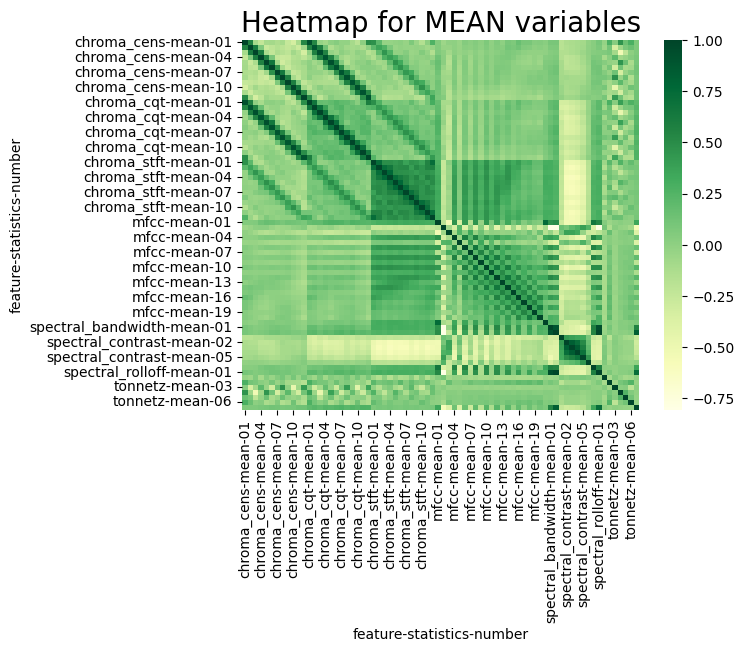

In [45]:
spike_cols = [col for col in X.columns if 'mean' in col] 
sns.heatmap(X[spike_cols].corr(), cmap='YlGn') 

plt.title('Heatmap for MEAN variables', fontsize = 20) 
plt.xticks(fontsize = 10) 
plt.yticks(fontsize = 10);

Nel'heatmap si possono notare dei blocchi di colore omogeneo. Quelli centrati sulla diagonale mettono in evidenza un'osservazione che ci saremmo potuti immaginare anche senza mappa: le stesse misurazioni fatte con parametri diversi (per esempio chroma_stft_10, chroma_stft_07...) sono altamente correlate tra di loro. Osserviamo però che blocchi omogenei sono presenti anche lontani dalla diagonale, questi mettono in evidenza della correlazione anche tra metriche diverse! Queste correlazioni possono essere sfruttate per ridurre la dimensionalità.

## Selezione delle feature più rilevanti

Successivamente, abbiamo applicato la **PCA (Principal Component Analysis)** per ridurre la dimensionalità del dataset. Questa tecnica ci ha permesso di comprimere le informazioni contenute nelle feature originali in un numero inferiore di componenti principali, preservando la maggior parte della varianza nei dati. La riduzione della dimensionalità è stata utile per semplificare il modello, migliorare l'efficienza computazionale e, in alcuni casi, ridurre il rischio di overfitting.

Il grafico sotto mostra che la maggiorparte della varianza del dataset è catturata da meno di 20 componenti.

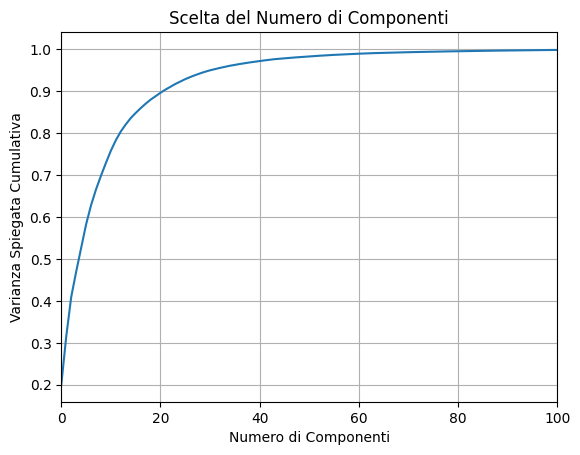

In [46]:
pca = PCA().fit(X)  # PCA senza specificare componenti
plt.xlim(0, 100)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Numero di Componenti")
plt.ylabel("Varianza Spiegata Cumulativa")
plt.title("Scelta del Numero di Componenti")
plt.grid()
plt.show()

Estraiamo queste componenti e proiettiamo il dataset nel sottospazio generato dai loro autovettori. Allora la dimensionalità del dataset viene ridotta notevolmente.

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42) 

print("Forma originale:", X_train.shape)
d = 20
pca = PCA(n_components=d)  # Riduzione a 20 componenti
X_train = pca.fit_transform(X_train)
X_test = pca.fit_transform(X_test)
print("Dopo PCA:", X_train.shape)

Forma originale: (22481, 518)
Dopo PCA: (22481, 20)


Vediamo ora quali sono le feature che abbiamo selezionato e "quanta" varianza spiegano

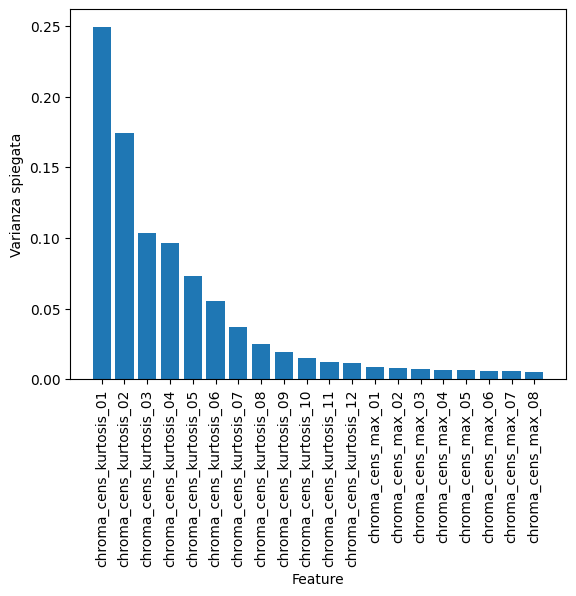

In [48]:
col_names = [name+"_"+stat+"_"+parameter for (name, stat, parameter) in X.columns]

important_features = np.abs(pca.components_[0])  # Prendi il valore assoluto della prima componente
feature_importance = list(zip(col_names, pca.explained_variance_ratio_))
feature_importance.sort(key=lambda x: x[1], reverse=True)  # Ordina per importanza
pca_feature_importance = feature_importance[:20]
pca_feature_importance_keys = [feature for (feature, value) in pca_feature_importance]
pca_feature_importance_value = [value for (feature, value) in pca_feature_importance]

fig, ax = plt.subplots()

# Creazione del bar chart
ax.bar(pca_feature_importance_keys ,pca_feature_importance_value)

# Aggiungere etichette e titolo
ax.set_xlabel('Feature')
ax.set_ylabel('Varianza spiegata')
plt.xticks(rotation=90)

# Mostrare il grafico
plt.show()

Da ora in poi useremo solo queste feature per addestrare i modelli.

# Modelli

Per affrontare il compito di classificazione del genere musicale sul dataset **FMA (Free Music Archive)**, sono stati testati diversi modelli di machine learning al fine di confrontarne le performance e identificare l'approccio più efficace. Ogni modello scelto rappresenta una tecnica classica o avanzata di classificazione, in grado di gestire il tipo di dati e le feature pre-estratte dal dataset.

I modelli implementati comprendono:

- **Support Vector Machine (SVM)**
- **Decision Tree**
- **Bagging**
- **Boosting**
- **Rete Neurale**
- **Softmax Regression**
- **Gaussian Discriminant Analysis (GDA)**
- **k-Nearest Neighbors (kNN)**
- **Locally-weighted Softmax Regression**

Questi modelli sono stati scelti per sfruttare diversi approcci al machine learning, esplorando tanto metodi parametrici quanto non-parametrici, e approcci basati su ensemble per massimizzare la performance nel task di classificazione automatica del genere musicale.

Per ogni modello che sperimentiamo riportiamo la matrice di confusione e le metriche più importanti (Guarda cella sotto).

In [49]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        xticklabels=classes,
        yticklabels=classes,
        title=title,
        ylabel='True label',
        xlabel='Predicted label'
    )
    plt.setp(
        ax.get_xticklabels(),
        rotation=45,
        ha='right',
        rotation_mode='anchor'
    )
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), ha='center', va='center', color='white' if cm[i, j] > thresh else 'black')
    fig.tight_layout()
    return ax

def valuate(clf, x_test, y_test):
    y_pred = clf.predict(x_test)
    print(classification_report(y_test, y_pred))
    plot_confusion_matrix(y_test, y_pred, classes=clf.classes_, title='Confusion matrix')